In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from xgboost import XGBClassifier 
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
import math

from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, balanced_accuracy_score
RANDOM_STATE = 42

# load data

In [79]:
X = np.load("Descriptor1_complete_features.npy")  
# X = np.load("Descriptor1_complete_features_new.npy")  
# X = np.load("Descriptor1_complete_features_stats.npy")   # w mean std of eigenvals
y = np.load("Descriptor1_complete_targets.npy")   

# X = X[:, :-1]
print(X.shape)

(1452, 147)


# class imbalance ratio

In [80]:
unique, counts = np.unique(y, return_counts=True)
for label, count in zip(unique, counts):
    print(f"Class {label}: {count} samples ({count/len(y):.2%})")

Class 0: 969 samples (66.74%)
Class 1: 483 samples (33.26%)


# identifying columns with >= 99 % zeros

In [81]:
# first 144 
X_eig = X[:, :144]

# how often each column is zero 
zero_rate = (X_eig == 0).mean(axis=0)
nonzero_count = (X_eig != 0).sum(axis=0)

# sorted summary (most-zero first)
order = np.argsort(-zero_rate)
summary = pd.DataFrame({
    "eig_col": order,                 # 0-based index within the 144 eig cols
    "zero_rate": zero_rate[order],
    "nonzero_count": nonzero_count[order]
})
print(summary.head(100).to_string(index=False))

# columns that are ≥99% zero
cols_99 = np.where(zero_rate >= 0.99)[0]
print("\nCols ≥99% zero (0-based):", cols_99.tolist())        #index start from 0 
#print("Cols ≥99% zero (1-based):", (cols_99 + 1).tolist())   #index start from 1 

 eig_col  zero_rate  nonzero_count
     143   0.999311              1
     128   0.999311              1
     129   0.999311              1
     130   0.999311              1
     131   0.999311              1
     132   0.999311              1
     133   0.999311              1
     134   0.999311              1
     142   0.999311              1
     136   0.999311              1
     137   0.999311              1
     138   0.999311              1
     139   0.999311              1
     140   0.999311              1
     141   0.999311              1
     135   0.999311              1
     112   0.998623              2
     113   0.998623              2
     114   0.998623              2
     115   0.998623              2
     116   0.998623              2
     117   0.998623              2
     118   0.998623              2
     121   0.998623              2
     120   0.998623              2
     122   0.998623              2
     123   0.998623              2
     124   0.998623 

# distribution of feature sized (before padding) 

n=1452 | mean=17.527 | median=13.000 | std=16.461


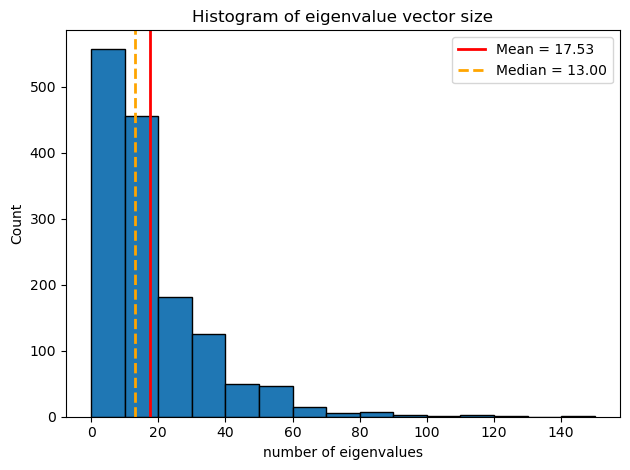

In [82]:
vals = X[:, -1]

# Compute stats
vals_mean = float(np.mean(vals))
vals_median = float(np.median(vals))
vals_std = float(np.std(vals, ddof=1)) if vals.size > 1 else float("nan")

print(f"n={vals.size} | mean={vals_mean:.3f} | median={vals_median:.3f} | std={vals_std:.3f}")

bin_width = 10
min_edge = math.floor(vals.min() / bin_width) * bin_width
max_edge = math.ceil(vals.max() / bin_width) * bin_width
bins = np.arange(min_edge, max_edge + bin_width, bin_width)

# Histogram
plt.figure()
plt.hist(vals, bins=bins, edgecolor="black")
plt.axvline(vals_mean, color="red", linestyle='-', linewidth=2, label=f"Mean = {vals_mean:.2f}")
plt.axvline(vals_median, color="orange", linestyle='--', linewidth=2, label=f"Median = {vals_median:.2f}")
plt.xlabel("number of eigenvalues")
plt.ylabel("Count")
plt.title("Histogram of eigenvalue vector size")
plt.legend()
plt.tight_layout()
plt.show()



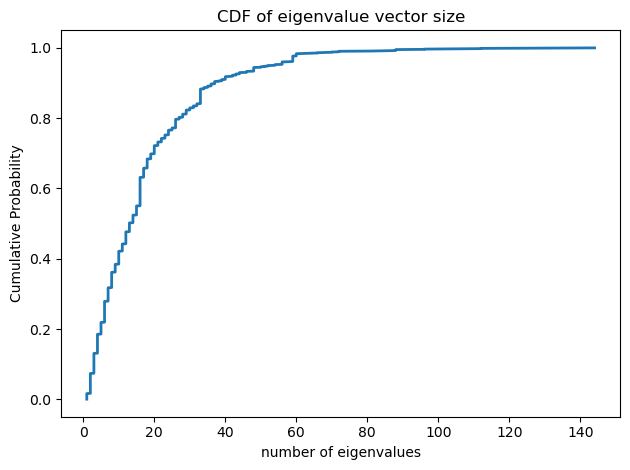

In [83]:
# CDF
plt.figure()
sorted_vals = np.sort(vals)
cdf = np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
plt.plot(sorted_vals, cdf, linewidth=2)
plt.xlabel("number of eigenvalues")
plt.ylabel("Cumulative Probability")
plt.title("CDF of eigenvalue vector size")
plt.tight_layout()
plt.show()

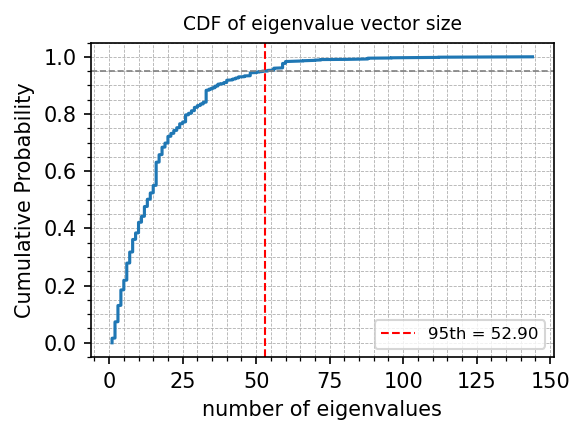

In [84]:
#  CDF with 0.95 marker
plt.figure(figsize=(4, 3), dpi=150)
sorted_vals = np.sort(vals)
cdf = np.linspace(0, 1, len(sorted_vals), endpoint=True)

plt.plot(sorted_vals, cdf, linewidth=1.5)

# 95th percentile
p95 = np.percentile(vals, 95)
plt.axvline(p95, color='r', linestyle='--', linewidth=1, label=f"95th = {p95:.2f}")
plt.axhline(0.95, color='gray', linestyle='--', linewidth=0.8)

plt.xlabel("number of eigenvalues")
plt.ylabel("Cumulative Probability")
plt.title("CDF of eigenvalue vector size", fontsize=9)
plt.legend(fontsize=8, loc="lower right")

plt.grid(True, which='both', linestyle='--', linewidth=0.4)
plt.minorticks_on()

plt.tight_layout()
plt.show()


# keeping top 52 + meta data (charge/spin/size)

In [85]:
# Eigenvalues + meta data 
K = 52 
X = np.hstack([X[:, :K], X[:, -3:]])

print( "Trimmed shape:", X.shape)

Trimmed shape: (1452, 55)


# train test split

In [86]:
# 20/80 split. 
# 20 % for our hold out test set 
# 80 % for hyperparam tuning, ...
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,        # preserve 66/34 balance
    random_state=RANDOM_STATE
)

print("Train/Val size:", X_trainval.shape[0])
print("Test size:", X_test.shape[0])

Train/Val size: 1161
Test size: 291


# XGB selecting k & params

In [87]:
RANDOM_STATE = 42
from sklearn.metrics import make_scorer, recall_score

neg = (y_trainval == 0).sum()
pos = (y_trainval == 1).sum()
spw = neg / max(pos, 1)

K_list = [5,6,7,8,9,10,11,12,13,14,15,16, 17, 18,19,20,22, 24,25, 30, 32,40,48,50,60,72]
# K_list = list(range(1, 73))
# K_list = [10,20,30,40,50,60,70]
K_list = [ 17, 18,19,20,22, 24,25, 30, 32,40,48,50,60,72]
K_list = list(range(15, 73))
K_list = list(range(8, 30))
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# search space 
param_dist = {
    "n_estimators": [ 200, 300, 400, 500 ], #, 600, 800, 1000],
    "max_depth": [3, 4, 5, 6, 8, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 1, 5],
    "min_child_weight": [1, 3, 5],
}

# scoring metrics
scoring = {"bal_acc": "balanced_accuracy", "acc": "accuracy"}

results = []          # list of dicts per K
search_by_K = {}      # keep the fitted search object to reuse the winner's best_estimator_

for K in K_list:
    print(K)
    Xi = np.hstack([X_trainval[:, :K], X_trainval[:, -3:]]) #top k eigneval + 3 metadata
    xgb = XGBClassifier(random_state=RANDOM_STATE, 
                        eval_metric="logloss", 
                       scale_pos_weight=spw
                       )
    search = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_dist,
        n_iter=50,
        scoring=scoring,
        refit="bal_acc",
        cv=inner_cv,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=0, 
    )
    
    search.fit(Xi, y_trainval)

    best_idx = search.best_index_
    splits = inner_cv.get_n_splits()

    # per-fold scores for std (balanced acc and accuracy)
    bal_folds = [search.cv_results_[f"split{i}_test_bal_acc"][best_idx] for i in range(splits)]
    acc_folds = [search.cv_results_[f"split{i}_test_acc"][best_idx]     for i in range(splits)]

    rec = {"K": K,
            "bal_mean": float(search.cv_results_["mean_test_bal_acc"][best_idx]),
            "bal_std":  float(np.std(bal_folds)),
            "acc_mean": float(search.cv_results_["mean_test_acc"][best_idx]),
            "acc_std":  float(np.std(acc_folds)),
            "best_params": search.best_params_,
    }
    results.append(rec)
    search_by_K[K] = search

8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


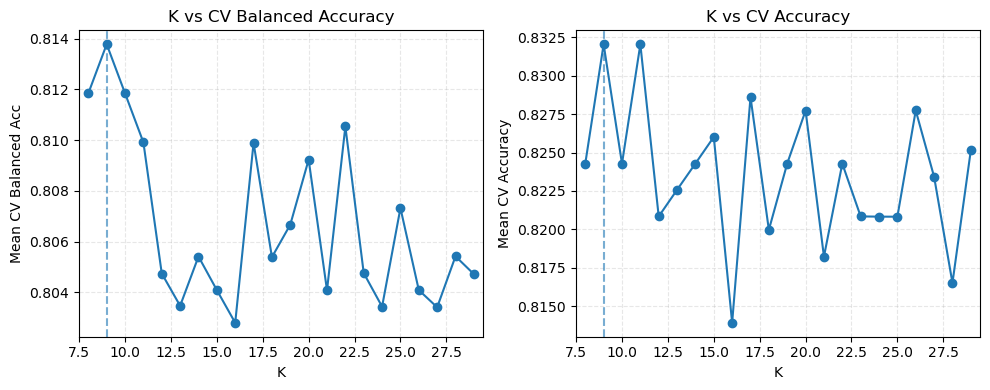

In [88]:
df = pd.DataFrame(results).sort_values("K").reset_index(drop=True)

# Best K by balanced accuracy (tie-break: acc_mean, then smaller K)
best_rec = max(df.to_dict("records"), key=lambda d: (d["bal_mean"], d["acc_mean"], -d["K"]))
K_star = best_rec["K"]

# Plots: left = K vs CV Balanced Acc, right = K vs CV Accuracy (no std/error bars)
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

# Left: balanced accuracy
axes[0].plot(df["K"], df["bal_mean"], "o-")
axes[0].axvline(K_star, linestyle="--", alpha=0.6)
axes[0].set_title("K vs CV Balanced Accuracy")
axes[0].set_xlabel("K")
axes[0].set_ylabel("Mean CV Balanced Acc")
axes[0].grid(alpha=0.3, linestyle="--")

# Right: accuracy
axes[1].plot(df["K"], df["acc_mean"], "o-")
axes[1].axvline(K_star, linestyle="--", alpha=0.6)
axes[1].set_title("K vs CV Accuracy")
axes[1].set_xlabel("K")
axes[1].set_ylabel("Mean CV Accuracy")
axes[1].grid(alpha=0.3, linestyle="--")

#  x-limits to tested Ks
axes[1].set_xlim(df["K"].min() - 0.5, df["K"].max() + 0.5)

plt.tight_layout()
plt.show()

In [89]:
#  summary sorted by balanced accuracy
results.sort(key=lambda d: d["bal_mean"], reverse=True)

print("\n=== XGB RandomizedSearch (5-fold), per-K summary — sorted by balanced accuracy ===")
print(" K   bal_mean  bal_sd   acc_mean  acc_sd ")
for r in results:
    print(f"{r['K']:2d}   {r['bal_mean']:.3f}    {r['bal_std']:.3f}    "
          f"{r['acc_mean']:.3f}    {r['acc_std']:.3f}")

# best k 
best = max(results, key=lambda d: (d["bal_mean"], d["acc_mean"], -d["K"]))
K_star = best["K"]
winner = best

print(f"\n>>> Selected K* = {K_star} by BEST bal_acc "
      f"(best bal_acc={best['bal_mean']:.3f}±{best['bal_std']:.3f}; "
      f"acc_mean={best['acc_mean']:.3f}±{best['acc_std']:.3f})")
print("Winner params:", winner.get("best_params"))


=== XGB RandomizedSearch (5-fold), per-K summary — sorted by balanced accuracy ===
 K   bal_mean  bal_sd   acc_mean  acc_sd 
 9   0.814    0.030    0.832    0.028
 8   0.812    0.026    0.824    0.025
10   0.812    0.016    0.824    0.015
22   0.811    0.016    0.824    0.014
11   0.810    0.016    0.832    0.016
17   0.810    0.018    0.829    0.012
20   0.809    0.027    0.828    0.024
25   0.807    0.011    0.821    0.011
19   0.807    0.023    0.824    0.020
28   0.805    0.013    0.817    0.009
14   0.805    0.022    0.824    0.017
18   0.805    0.020    0.820    0.014
23   0.805    0.028    0.821    0.022
12   0.805    0.024    0.821    0.022
29   0.805    0.024    0.825    0.020
15   0.804    0.018    0.826    0.015
26   0.804    0.021    0.828    0.015
21   0.804    0.025    0.818    0.025
13   0.803    0.017    0.823    0.012
24   0.803    0.025    0.821    0.020
27   0.803    0.022    0.823    0.019
16   0.803    0.023    0.814    0.023

>>> Selected K* = 9 by BEST bal_acc (

In [28]:
# # --- Manually set K* ---
# results.sort(key=lambda d: d["bal_mean"], reverse=True)

# print("\n=== XGB RandomizedSearch (5-fold), per-K summary — sorted by balanced accuracy ===")
# print(" K   bal_mean  bal_sd   acc_mean  acc_sd ")
# for r in results:
#     print(f"{r['K']:2d}   {r['bal_mean']:.3f}    {r['bal_std']:.3f}    "
#           f"{r['acc_mean']:.3f}    {r['acc_std']:.3f}")

# # Manually choose K*
# K_star = 22
# winner = next((r for r in results if r["K"] == K_star), None)
# if winner is None:
#     raise ValueError(f"K={K_star} not found in results.")

# print(f"\n>>> Manually selected K* = {K_star} "
#       f"(bal_acc={winner['bal_mean']:.3f}±{winner['bal_std']:.3f}; "
#       f"acc_mean={winner['acc_mean']:.3f}±{winner['acc_std']:.3f})")
# print("Winner params:", winner.get("best_params"))


In [30]:
# # slightly lower cutoff at inference 
# from sklearn.metrics import accuracy_score, recall_score, precision_score, balanced_accuracy_score

# # 1) Pick K* the same way (by balanced accuracy, tie-break by acc, then smaller K)
# best = max(results, key=lambda d: (d["bal_mean"], d["acc_mean"], -d["K"]))
# K_star = best["K"]
# best_search = search_by_K[K_star]
# best_model = best_search.best_estimator_  # already refit on all trainval folds

# # 2) Build the matching feature views for K*
# Xi_train = np.hstack([X_trainval[:, :K_star], X_trainval[:, -3:]])
# Xi_test  = np.hstack([X_test[:, :K_star],     X_test[:, -3:]])

# #  reduce the decision cutoff 
# THRESHOLD = 0.47

# # 4) Predict with the adjusted threshold
# proba_train = best_model.predict_proba(Xi_train)[:, 1]
# y_pred_train = (proba_train >= THRESHOLD).astype(int)

# proba_test = best_model.predict_proba(Xi_test)[:, 1]
# y_pred_test = (proba_test >= THRESHOLD).astype(int)

# # 5) quick report
# print(f"K* = {K_star}, threshold = {THRESHOLD:.2f}")
# print("Train  | Acc:",
#       f"{accuracy_score(y_trainval, y_pred_train):.3f}",
#       "BalAcc:", f"{balanced_accuracy_score(y_trainval, y_pred_train):.3f}",
#       "Recall:", f"{recall_score(y_trainval, y_pred_train, zero_division=0):.3f}",
#       "Prec:",   f"{precision_score(y_trainval, y_pred_train, zero_division=0):.3f}")

# print("Test   | Acc:",
#       f"{accuracy_score(y_test, y_pred_test):.3f}",
#       "BalAcc:", f"{balanced_accuracy_score(y_test, y_pred_test):.3f}",
#       "Recall:", f"{recall_score(y_test, y_pred_test, zero_division=0):.3f}",
#       "Prec:",   f"{precision_score(y_test, y_pred_test, zero_division=0):.3f}")


K* = 22, threshold = 0.47
Train  | Acc: 0.936 BalAcc: 0.947 Recall: 0.979 Prec: 0.851
Test   | Acc: 0.814 BalAcc: 0.817 Recall: 0.825 Prec: 0.684


In [90]:
print(K_star)

# Refit on all train/val with K* and evaluate on test 
X_trainval_k = np.hstack([X_trainval[:, :K_star], X_trainval[:, -3:]])
X_test_k     = np.hstack([X_test[:, :K_star],     X_test[:, -3:]])

best_xgb = search_by_K[K_star].best_estimator_   # already refit on all train/val by RandomizedSearchCV
best_xgb.fit(X_trainval_k, y_trainval)           #  re-fit 

# Train eval
y_pred_tr = best_xgb.predict(X_trainval_k)
y_prob_tr = best_xgb.predict_proba(X_trainval_k)[:, 1]
print("\n=== XGBoostTrain Set Performance ===")
print(classification_report(y_trainval, y_pred_tr, digits=2))
print("Train Accuracy:", accuracy_score(y_trainval, y_pred_tr))
print("Train Balanced Acc:", balanced_accuracy_score(y_trainval, y_pred_tr))
print("Train ROC-AUC:", roc_auc_score(y_trainval, y_prob_tr))
print("Train PR-AUC:", average_precision_score(y_trainval, y_prob_tr))

y_pred_te = best_xgb.predict(X_test_k)
y_prob_te = best_xgb.predict_proba(X_test_k)[:, 1]
print("\n=== XGBoost Test Set Performance ===")
print(classification_report(y_test, y_pred_te, digits=2))
print("Test Accuracy:", accuracy_score(y_test, y_pred_te))
print("Test Balanced Acc:", balanced_accuracy_score(y_test, y_pred_te))
print("Test ROC-AUC:", roc_auc_score(y_test, y_prob_te))
print("Test PR-AUC:", average_precision_score(y_test, y_prob_te))

9

=== XGBoostTrain Set Performance ===
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       775
           1       0.96      1.00      0.98       386

    accuracy                           0.98      1161
   macro avg       0.98      0.99      0.98      1161
weighted avg       0.98      0.98      0.98      1161

Train Accuracy: 0.983634797588286
Train Balanced Acc: 0.9870917599866288
Train ROC-AUC: 0.9980210596690624
Train PR-AUC: 0.9954473671479127

=== XGBoost Test Set Performance ===
              precision    recall  f1-score   support

           0       0.89      0.86      0.87       194
           1       0.73      0.78      0.76        97

    accuracy                           0.83       291
   macro avg       0.81      0.82      0.81       291
weighted avg       0.84      0.83      0.83       291

Test Accuracy: 0.8316151202749141
Test Balanced Acc: 0.8195876288659794
Test ROC-AUC: 0.8837017748963758
Test PR-AUC: 0.81572605

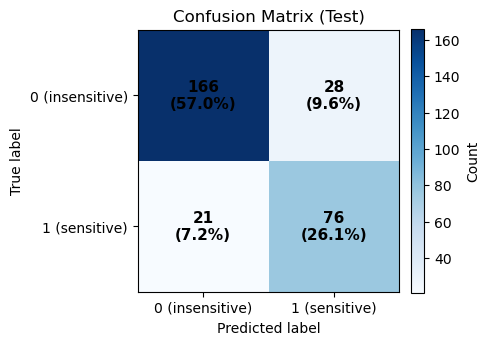

In [92]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_te, labels=[0,1])  # [[TN, FP],[FN, TP]]
TN, FP, FN, TP = cm.ravel()
N = cm.sum()

fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(cm, cmap="Blues")
ax.set_title("Confusion Matrix (Test)")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_xticks([0,1]); ax.set_xticklabels(["0 (insensitive)", "1 (sensitive)"])
ax.set_yticks([0,1]); ax.set_yticklabels(["0 (insensitive)", "1 (sensitive)"])

for (i, j), v in np.ndenumerate(cm):
    pct = 100.0 * v / N
    ax.text(j, i, f"{v}\n({pct:.1f}%)", ha="center", va="center",
            fontsize=11, color="black", fontweight="bold")

cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Count")
plt.tight_layout()
plt.show()


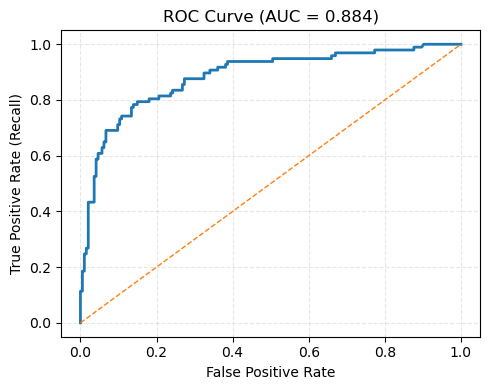

In [93]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thr = roc_curve(y_test, y_prob_te)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, lw=2)
plt.plot([0,1], [0,1], linestyle="--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title(f"ROC Curve (AUC = {roc_auc:.3f})")
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()


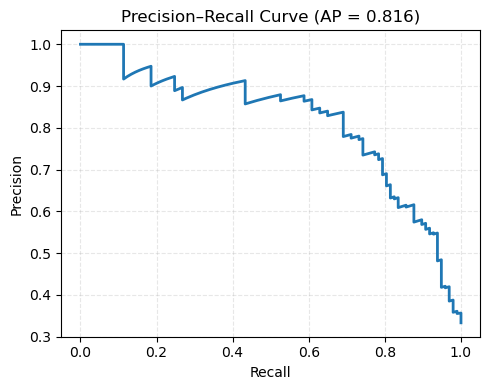

In [94]:
from sklearn.metrics import precision_recall_curve, average_precision_score

prec, rec, thr = precision_recall_curve(y_test, y_prob_te)
ap = average_precision_score(y_test, y_prob_te)

plt.figure(figsize=(5,4))
plt.plot(rec, prec, lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve (AP = {ap:.3f})")
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()


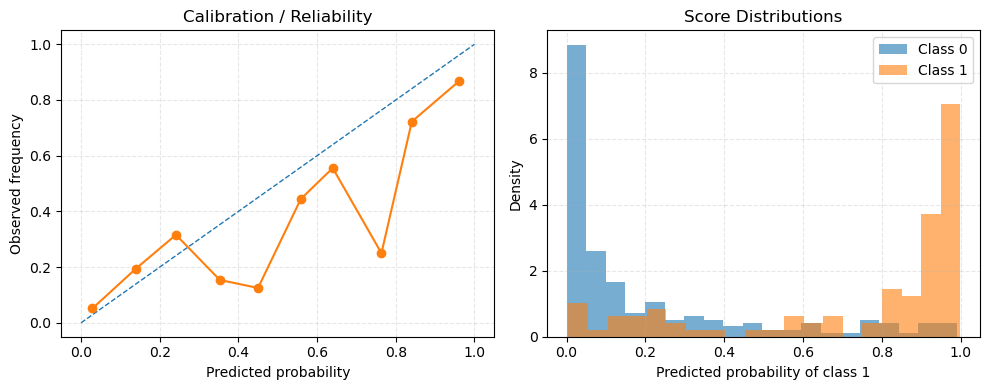

In [95]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, y_prob_te, n_bins=10, strategy="uniform")

fig, ax = plt.subplots(1, 2, figsize=(10,4))

# Reliability
ax[0].plot([0,1], [0,1], "--", lw=1)
ax[0].plot(prob_pred, prob_true, marker="o")
ax[0].set_title("Calibration / Reliability")
ax[0].set_xlabel("Predicted probability")
ax[0].set_ylabel("Observed frequency")
ax[0].grid(alpha=0.3, linestyle="--")

# Histogram of scores by class
ax[1].hist(y_prob_te[y_test==0], bins=20, alpha=0.6, label="Class 0", density=True)
ax[1].hist(y_prob_te[y_test==1], bins=20, alpha=0.6, label="Class 1", density=True)
ax[1].set_title("Score Distributions")
ax[1].set_xlabel("Predicted probability of class 1")
ax[1].set_ylabel("Density")
ax[1].legend()
ax[1].grid(alpha=0.3, linestyle="--")

plt.tight_layout()
plt.show()


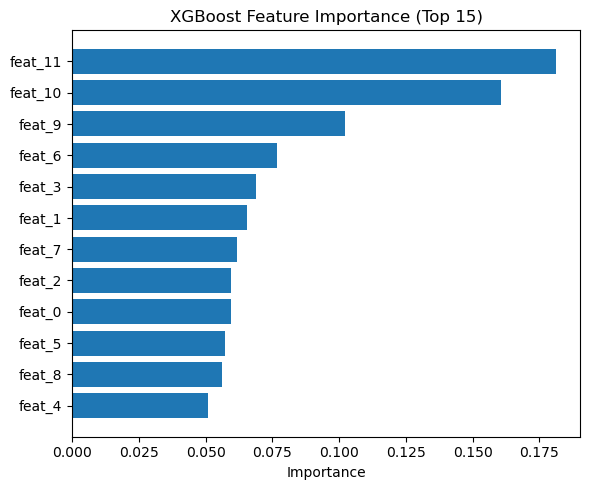

In [96]:
feat_names = [f"feat_{i}" for i in range(X_test_k.shape[1])]
imp = pd.Series(best_xgb.feature_importances_, index=feat_names).sort_values(ascending=False)

top = imp.head(15).iloc[::-1]
plt.figure(figsize=(6,5))
plt.barh(top.index, top.values)
plt.xlabel("Importance")
plt.title("XGBoost Feature Importance (Top 15)")
plt.tight_layout()
plt.show()


/opt/anaconda3/lib/python3.12/site-packages/shap/explainers/_tree.py:253: FutureWarning: In the future, passing feature_perturbation='interventional' without providing a background dataset will raise an error. Please provide a background dataset to continue using the interventional approach or set feature_perturbation='auto' to automatically switch approaches.
  warnings.warn(


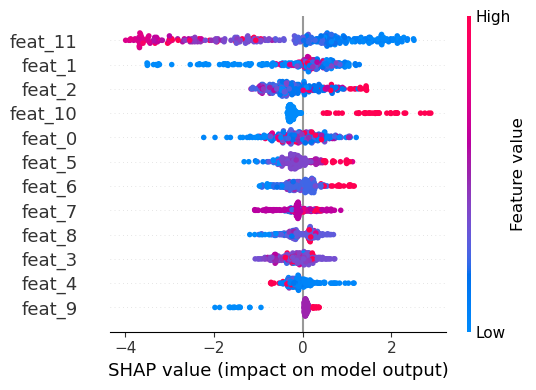

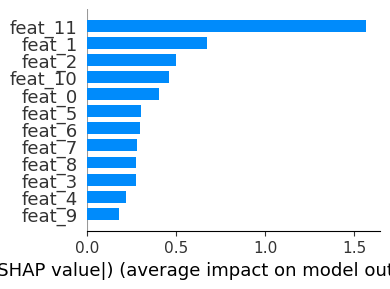

In [97]:
import shap

feat_names = [f"feat_{i}" for i in range(X_test_k.shape[1])]
Xtr_df = pd.DataFrame(X_trainval_k, columns=feat_names)
Xte_df = pd.DataFrame(X_test_k,     columns=feat_names)

explainer = shap.TreeExplainer(best_xgb, feature_perturbation="interventional")
shap_vals = explainer.shap_values(Xte_df)

# 1) Beeswarm summary
plt.figure(figsize=(5.5,4))
shap.summary_plot(
    shap_vals, Xte_df,
    show=False,
    max_display=15,
    plot_size=(5.5,4),
)
plt.tight_layout()
plt.show()

# 2) Bar summary
plt.figure(figsize=(4,3))
shap.summary_plot(
    shap_vals, Xte_df,
    plot_type="bar",
    show=False,
    max_display=15,
    plot_size=(4,3),
)
plt.tight_layout()
plt.show()


In [98]:
PRINT_REPORTS = False  # set True to print full classification_report per K

rows = []

for K in sorted(K_list):
    # Slice features for this K
    X_trainval_k = np.hstack([X_trainval[:, :K], X_trainval[:, -3:]])
    X_test_k     = np.hstack([X_test[:, :K],     X_test[:, -3:]])

    # Best estimator for this K (from your RandomizedSearchCV)
    best_xgb = search_by_K[K].best_estimator_

    # (Re)fit on entire train/val for fairness
    best_xgb.fit(X_trainval_k, y_trainval)

    # --- Train metrics ---
    y_pred_tr = best_xgb.predict(X_trainval_k)
    y_prob_tr = best_xgb.predict_proba(X_trainval_k)[:, 1]
    tr_acc    = accuracy_score(y_trainval, y_pred_tr)
    tr_bal    = balanced_accuracy_score(y_trainval, y_pred_tr)
    tr_roc    = roc_auc_score(y_trainval, y_prob_tr)
    tr_pr     = average_precision_score(y_trainval, y_prob_tr)

    # --- Test metrics ---
    y_pred_te = best_xgb.predict(X_test_k)
    y_prob_te = best_xgb.predict_proba(X_test_k)[:, 1]
    te_acc    = accuracy_score(y_test, y_pred_te)
    te_bal    = balanced_accuracy_score(y_test, y_pred_te)
    te_roc    = roc_auc_score(y_test, y_prob_te)
    te_pr     = average_precision_score(y_test, y_prob_te)

    rows.append({
        "K": K,
        "train_acc": tr_acc, "train_bal_acc": tr_bal, "train_roc_auc": tr_roc, "train_pr_auc": tr_pr,
        "test_acc": te_acc,  "test_bal_acc": te_bal,  "test_roc_auc": te_roc,  "test_pr_auc": te_pr,
        "best_params": search_by_K[K].best_params_
    })

    if PRINT_REPORTS:
        print(f"\n=== K={K} ===")
        print("Train report:")
        print(classification_report(y_trainval, y_pred_tr, digits=3))
        print("Test report:")
        print(classification_report(y_test, y_pred_te, digits=3))

# Summary table (sorted by test balanced accuracy)
df = pd.DataFrame(rows).sort_values("test_bal_acc", ascending=False).reset_index(drop=True)
with pd.option_context("display.max_colwidth", 200, "display.precision", 3):
    print("\n=== Summary across all K (sorted by TEST balanced accuracy) ===")
    print(df[["K","test_bal_acc","test_acc","test_pr_auc","test_roc_auc","train_bal_acc","train_acc"]].to_string(index=False))


=== Summary across all K (sorted by TEST balanced accuracy) ===
 K  test_bal_acc  test_acc  test_pr_auc  test_roc_auc  train_bal_acc  train_acc
27         0.825     0.835        0.812         0.879          0.987      0.983
29         0.820     0.832        0.817         0.879          0.988      0.984
 9         0.820     0.832        0.816         0.884          0.987      0.984
22         0.812     0.821        0.813         0.883          0.944      0.937
20         0.809     0.821        0.812         0.879          0.987      0.983
11         0.809     0.828        0.805         0.878          0.989      0.987
25         0.807     0.811        0.800         0.872          0.937      0.935
14         0.807     0.821        0.791         0.871          0.973      0.966
23         0.807     0.818        0.801         0.872          0.955      0.949
16         0.807     0.811        0.800         0.869          0.916      0.913
26         0.804     0.821        0.808         0.876  

In [99]:
from sklearn.metrics import recall_score

PRINT_REPORTS = False  # set True to print full classification_report per K

rows = []

for K in sorted(K_list):
    # Slice features for this K
    X_trainval_k = np.hstack([X_trainval[:, :K], X_trainval[:, -3:]])
    X_test_k     = np.hstack([X_test[:, :K],     X_test[:, -3:]])

    # Best estimator for this K (from your RandomizedSearchCV)
    best_xgb = search_by_K[K].best_estimator_

    # (Re)fit on entire train/val for fairness
    best_xgb.fit(X_trainval_k, y_trainval)

    # --- Train metrics ---
    y_pred_tr = best_xgb.predict(X_trainval_k)
    y_prob_tr = best_xgb.predict_proba(X_trainval_k)[:, 1]
    tr_acc    = accuracy_score(y_trainval, y_pred_tr)
    tr_bal    = balanced_accuracy_score(y_trainval, y_pred_tr)
    tr_roc    = roc_auc_score(y_trainval, y_prob_tr)
    tr_pr     = average_precision_score(y_trainval, y_prob_tr)
    tr_rec1   = recall_score(y_trainval, y_pred_tr, pos_label=1)

    # --- Test metrics ---
    y_pred_te = best_xgb.predict(X_test_k)
    y_prob_te = best_xgb.predict_proba(X_test_k)[:, 1]
    te_acc    = accuracy_score(y_test, y_pred_te)
    te_bal    = balanced_accuracy_score(y_test, y_pred_te)
    te_roc    = roc_auc_score(y_test, y_prob_te)
    te_pr     = average_precision_score(y_test, y_prob_te)
    te_rec1   = recall_score(y_test, y_pred_te, pos_label=1)

    rows.append({
        "K": K,
        "train_acc": tr_acc, "train_bal_acc": tr_bal, "train_roc_auc": tr_roc, "train_pr_auc": tr_pr,
        "train_recall_1": tr_rec1, 
        "test_acc": te_acc,  "test_bal_acc": te_bal,  "test_roc_auc": te_roc,  "test_pr_auc": te_pr,
        "test_recall_1": te_rec1,   
        "best_params": search_by_K[K].best_params_
    })

    if PRINT_REPORTS:
        print(f"\n=== K={K} ===")
        # print("Train report:")
        # print(classification_report(y_trainval, y_pred_tr, digits=3))
        print("Test report:")
        print(classification_report(y_test, y_pred_te, digits=3))

# Summary table (sorted by test balanced accuracy)
df = pd.DataFrame(rows).sort_values("test_bal_acc", ascending=False).reset_index(drop=True)
with pd.option_context("display.max_colwidth", 200, "display.precision", 3):
    print("\n=== Summary across all K (sorted by TEST balanced accuracy) ===")
    print(df[[
        "K","test_bal_acc","test_acc","test_recall_1","test_pr_auc","test_roc_auc",
        "train_bal_acc","train_acc","train_recall_1"
    ]].to_string(index=False))



=== Summary across all K (sorted by TEST balanced accuracy) ===
 K  test_bal_acc  test_acc  test_recall_1  test_pr_auc  test_roc_auc  train_bal_acc  train_acc  train_recall_1
27         0.825     0.835          0.794        0.812         0.879          0.987      0.983           1.000
29         0.820     0.832          0.784        0.817         0.879          0.988      0.984           1.000
 9         0.820     0.832          0.784        0.816         0.884          0.987      0.984           0.997
22         0.812     0.821          0.784        0.813         0.883          0.944      0.937           0.966
20         0.809     0.821          0.773        0.812         0.879          0.987      0.983           1.000
11         0.809     0.828          0.753        0.805         0.878          0.989      0.987           0.995
25         0.807     0.811          0.794        0.800         0.872          0.937      0.935           0.946
14         0.807     0.821          0.763      

# feature importance

In [104]:
# feat_names = [f"feat_{i}" for i in range(X_trainval_k.shape[1])]
# print("all features: ", feat_names)

# imp = pd.Series(best_xgb.feature_importances_, index=feat_names).sort_values(ascending=False)

# print("\nTop 20 features:")
# print(imp.head(20).round(4))

# plt.figure(figsize=(6,5))
# imp.head(20).iloc[::-1].plot(kind="barh")
# plt.title("XGBoost Feature Importance")
# plt.xlabel("Importance")
# plt.tight_layout()
# plt.show()

# X_trainval_k.shape

# RF selecting K & params

In [101]:
RANDOM_STATE = 42

K_list = [8,9,10,11]
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

param_dist = {                                  #add lr later
    "n_estimators": [ 200, 300, 400, 500 ], #, 600, 800, 1000],
    "max_depth": [None, 6, 10, 14],
    "min_samples_leaf": [1, 2, 5, 10],
    "min_samples_split": [2, 5, 10],
    "max_features": ["sqrt", "log2", 0.3, 0.5, 0.7],
    "bootstrap": [True],
    "class_weight": ["balanced", "balanced_subsample"],
}

# param_dist = {                                  #add lr later
#     "n_estimators": [100],
#     "max_depth": [10],
#     "class_weight": ["balanced"],
# }

# scoring 
scoring = {"bal_acc": "balanced_accuracy", "acc": "accuracy"}

results = []          # list of dicts per K
search_by_K = {}      # keep the fitted search object to reuse the winner's best_estimator_

for K in K_list:
    print(K)
    Xi = np.hstack([X_trainval[:, :K], X_trainval[:, -3:]])  # top-K eig + 3 metadata
    rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)

    search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_dist,
        n_iter=50,
        scoring=scoring,
        refit="bal_acc",
        cv=inner_cv,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=0,
    )

#     search = GridSearchCV(
#     estimator=rf,
#     param_grid=param_dist,    # or use your existing `param_dist` if it's grid-like
#     scoring=scoring,          # e.g., {"bal_acc": make_scorer(balanced_accuracy_score), "recall": "recall"}
#     refit="bal_acc",          # same as your RandomizedSearchCV example
#     cv=inner_cv,
#     n_jobs=-1,
#     verbose=0,
# )


    search.fit(Xi, y_trainval)

    best_idx = search.best_index_
    splits = inner_cv.get_n_splits()

    # per-fold scores for std (balanced acc and accuracy)
    bal_folds = [search.cv_results_[f"split{i}_test_bal_acc"][best_idx] for i in range(splits)]
    acc_folds = [search.cv_results_[f"split{i}_test_acc"][best_idx]     for i in range(splits)]

    rec = {"K": K,
            "bal_mean": float(search.cv_results_["mean_test_bal_acc"][best_idx]),
            "bal_std":  float(np.std(bal_folds)),
            "acc_mean": float(search.cv_results_["mean_test_acc"][best_idx]),
            "acc_std":  float(np.std(acc_folds)),
            "best_params": search.best_params_,}
            
    results.append(rec)
    search_by_K[K] = search


8
9
10
11


In [102]:
# Print summary sorted by balanced accuracy 
results.sort(key=lambda d: d["bal_mean"], reverse=True)

print("\n===  rf RandomizedSearch (5-fold), per-K summary — sorted by balanced accuracy ===")
print(" K   bal_mean  bal_sd   acc_mean  acc_sd   ")
for r in results:
    print(f"{r['K']:2d}   {r['bal_mean']:.3f}    {r['bal_std']:.3f}    "
          f"{r['acc_mean']:.3f}    {r['acc_std']:.3f}")

#  best k 
best = max(
    results,
    key=lambda d: (d["bal_mean"], d["acc_mean"], -d["K"])
)
K_star = best["K"]
winner = best

print(f"\n>>> Selected K* = {K_star} by BEST bal_acc "
      f"(bal_acc={best['bal_mean']:.3f}±{best['bal_std']:.3f}; "
      f"acc_mean={best['acc_mean']:.3f}±{best['acc_std']:.3f})")
print("Winner params:", winner.get("best_params"))



===  rf RandomizedSearch (5-fold), per-K summary — sorted by balanced accuracy ===
 K   bal_mean  bal_sd   acc_mean  acc_sd   
 9   0.797    0.011    0.825    0.013
10   0.796    0.014    0.823    0.012
 8   0.796    0.020    0.826    0.016
11   0.795    0.008    0.824    0.011

>>> Selected K* = 9 by BEST bal_acc (bal_acc=0.797±0.011; acc_mean=0.825±0.013)
Winner params: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 0.5, 'max_depth': 14, 'class_weight': 'balanced_subsample', 'bootstrap': True}


In [103]:
# Refit on all train/val with K* and evaluate on test.
X_trainval_k = np.hstack([X_trainval[:, :K_star], X_trainval[:, -3:]])
X_test_k     = np.hstack([X_test[:, :K_star],     X_test[:, -3:]])

best_rf = search_by_K[K_star].best_estimator_   # already refit on all train/val by RandomizedSearchCV
best_rf.fit(X_trainval_k, y_trainval)           # (harmless re-fit to be explicit)

# Train eval
y_pred_tr = best_rf.predict(X_trainval_k)
y_prob_tr =best_rf.predict_proba(X_trainval_k)[:, 1]
print("\n=== Train Set Performance ===")
print(classification_report(y_trainval, y_pred_tr, digits=3))
print("Train Accuracy:", accuracy_score(y_trainval, y_pred_tr))
print("Train Balanced Acc:", balanced_accuracy_score(y_trainval, y_pred_tr))
print("Train ROC-AUC:", roc_auc_score(y_trainval, y_prob_tr))
print("Train PR-AUC:", average_precision_score(y_trainval, y_prob_tr))

# Test eval 
y_pred_te = best_rf.predict(X_test_k)
y_prob_te = best_rf.predict_proba(X_test_k)[:, 1]
print("\n=== Test Set Performance ===")
print(classification_report(y_test, y_pred_te, digits=3))
print("Test Accuracy:", accuracy_score(y_test, y_pred_te))
print("Test Balanced Acc:", balanced_accuracy_score(y_test, y_pred_te))
print("Test ROC-AUC:", roc_auc_score(y_test, y_prob_te))
print("Test PR-AUC:", average_precision_score(y_test, y_prob_te))


=== Train Set Performance ===
              precision    recall  f1-score   support

           0      0.984     0.972     0.978       775
           1      0.944     0.969     0.957       386

    accuracy                          0.971      1161
   macro avg      0.964     0.970     0.967      1161
weighted avg      0.971     0.971     0.971      1161

Train Accuracy: 0.970714900947459
Train Balanced Acc: 0.970262410162126
Train ROC-AUC: 0.9950459635634298
Train PR-AUC: 0.9883926790154627

=== Test Set Performance ===
              precision    recall  f1-score   support

           0      0.865     0.856     0.860       194
           1      0.717     0.732     0.724        97

    accuracy                          0.814       291
   macro avg      0.791     0.794     0.792       291
weighted avg      0.815     0.814     0.815       291

Test Accuracy: 0.8144329896907216
Test Balanced Acc: 0.7938144329896907
Test ROC-AUC: 0.8677595918801148
Test PR-AUC: 0.7972863665079731


# catBoost

In [75]:
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

RANDOM_STATE = 42

# --- class imbalance handling (match your spw logic) ---
neg = (y_trainval == 0).sum()
pos = (y_trainval == 1).sum()
spw = neg / max(pos, 1)  # weight for minority class 1
class_weights = [1.0, float(spw)]  # index 0 -> class 0, index 1 -> class 1

# --- K sweep (same semantics) ---
K_list = list(range(8, 10))

inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# CatBoost search space (mapped from your XGB grid)
# iterations ~ n_estimators; depth ~ max_depth; learning_rate same
# l2_leaf_reg ~ regularization; subsample via Bernoulli bootstrap; rsm ~ colsample_bytree
param_dist = {
    "iterations":        [200, 300, 400, 500],
    "depth":             [3, 4, 5, 6, 8, 10],
    "learning_rate":     [0.01, 0.05, 0.1, 0.2],
    "l2_leaf_reg":       [1, 3, 5],
    "bootstrap_type":    ["Bernoulli"],   # to enable subsample
    "subsample":         [0.6, 0.8, 1.0], # row sampling
    "rsm":               [0.6, 0.8, 1.0], # column sampling (per split)
}

# scoring dict identical to yours
scoring = {"bal_acc": "balanced_accuracy", "acc": "accuracy"}

results = []
search_by_K = {}

for K in K_list:
    print(K)
    # top-K eigenvalues + 3 metadata columns at the end (same as your Xi)
    Xi = np.hstack([X_trainval[:, :K], X_trainval[:, -3:]])

    # Base CatBoost estimator with sklearn API
    cbc = CatBoostClassifier(
        loss_function="Logloss",
        eval_metric="Logloss",     # metrics for logs; CV scoring controls selection
        class_weights=class_weights,
        random_seed=RANDOM_STATE,
        # Avoid early stopping inside CV to keep parity with your XGB search
        verbose=False
    )

    search = RandomizedSearchCV(
        estimator=cbc,
        param_distributions=param_dist,
        n_iter=50,
        scoring=scoring,
        refit="bal_acc",
        cv=inner_cv,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=0,
    )

    search.fit(Xi, y_trainval)

    best_idx = search.best_index_
    splits = inner_cv.get_n_splits()

    # per-fold scores for std (balanced acc and accuracy)
    bal_folds = [search.cv_results_[f"split{i}_test_bal_acc"][best_idx] for i in range(splits)]
    acc_folds = [search.cv_results_[f"split{i}_test_acc"][best_idx]     for i in range(splits)]

    rec = {
        "K": K,
        "bal_mean": float(search.cv_results_["mean_test_bal_acc"][best_idx]),
        "bal_std":  float(np.std(bal_folds)),
        "acc_mean": float(search.cv_results_["mean_test_acc"][best_idx]),
        "acc_std":  float(np.std(acc_folds)),
        "best_params": search.best_params_,
    }
    results.append(rec)
    search_by_K[K] = search



8
9


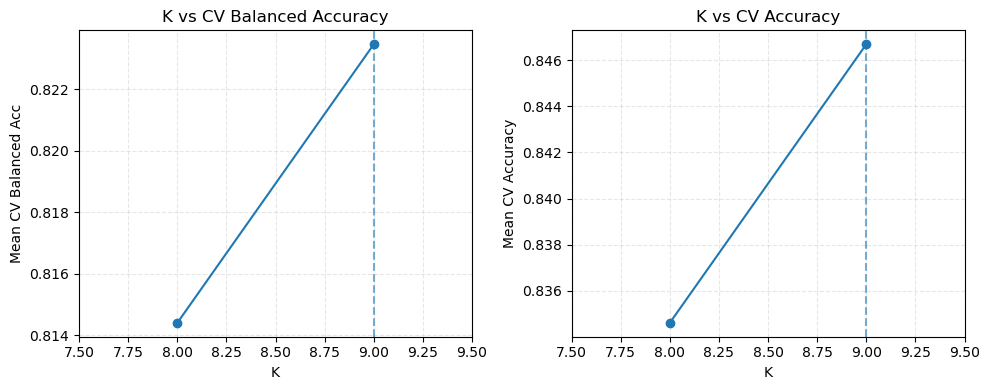


=== CatBoost RandomizedSearch (5-fold), per-K summary — sorted by balanced accuracy ===
 K   bal_mean  bal_sd   acc_mean  acc_sd 
 9   0.823    0.015    0.847    0.010
 8   0.814    0.014    0.835    0.011

>>> Selected K* = 9 by BEST bal_acc (best bal_acc=0.823±0.015; acc_mean=0.847±0.010)
Winner params: {'subsample': 0.6, 'rsm': 1.0, 'learning_rate': 0.1, 'l2_leaf_reg': 5, 'iterations': 400, 'depth': 10, 'bootstrap_type': 'Bernoulli'}


In [76]:
# --- summary DataFrame & pick K* (same tie-break rule) ---
df = pd.DataFrame(results).sort_values("K").reset_index(drop=True)
best_rec = max(df.to_dict("records"), key=lambda d: (d["bal_mean"], d["acc_mean"], -d["K"]))
K_star = best_rec["K"]

# --- plots (unchanged) ---
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

axes[0].plot(df["K"], df["bal_mean"], "o-")
axes[0].axvline(K_star, linestyle="--", alpha=0.6)
axes[0].set_title("K vs CV Balanced Accuracy")
axes[0].set_xlabel("K")
axes[0].set_ylabel("Mean CV Balanced Acc")
axes[0].grid(alpha=0.3, linestyle="--")

axes[1].plot(df["K"], df["acc_mean"], "o-")
axes[1].axvline(K_star, linestyle="--", alpha=0.6)
axes[1].set_title("K vs CV Accuracy")
axes[1].set_xlabel("K")
axes[1].set_ylabel("Mean CV Accuracy")
axes[1].grid(alpha=0.3, linestyle="--")
axes[1].set_xlim(df["K"].min() - 0.5, df["K"].max() + 0.5)

plt.tight_layout()
plt.show()

# --- sorted printout & winner selection (unchanged) ---
results.sort(key=lambda d: d["bal_mean"], reverse=True)

print("\n=== CatBoost RandomizedSearch (5-fold), per-K summary — sorted by balanced accuracy ===")
print(" K   bal_mean  bal_sd   acc_mean  acc_sd ")
for r in results:
    print(f"{r['K']:2d}   {r['bal_mean']:.3f}    {r['bal_std']:.3f}    "
          f"{r['acc_mean']:.3f}    {r['acc_std']:.3f}")

best = max(results, key=lambda d: (d["bal_mean"], d["acc_mean"], -d["K"]))
K_star = best["K"]
winner = best

print(f"\n>>> Selected K* = {K_star} by BEST bal_acc "
      f"(best bal_acc={best['bal_mean']:.3f}±{best['bal_std']:.3f}; "
      f"acc_mean={best['acc_mean']:.3f}±{best['acc_std']:.3f})")
print("Winner params:", winner.get("best_params"))


In [77]:
from sklearn.metrics import (
    classification_report, accuracy_score, balanced_accuracy_score,
    roc_auc_score, average_precision_score
)
import numpy as np

# Refit on all train/val with K* and evaluate on test
X_trainval_k = np.hstack([X_trainval[:, :K_star], X_trainval[:, -3:]])
X_test_k     = np.hstack([X_test[:, :K_star],     X_test[:, -3:]])

best_cat = search_by_K[K_star].best_estimator_   # already tuned on train/val via CV
best_cat.fit(X_trainval_k, y_trainval)           # final refit on full train/val

# Train eval
y_pred_tr = best_cat.predict(X_trainval_k).astype(int)
y_prob_tr = best_cat.predict_proba(X_trainval_k)[:, 1]

print("\n=== CatBoost Train Set Performance ===")
print(classification_report(y_trainval, y_pred_tr, digits=3))
print("Train Accuracy:", accuracy_score(y_trainval, y_pred_tr))
print("Train Balanced Acc:", balanced_accuracy_score(y_trainval, y_pred_tr))
print("Train ROC-AUC:", roc_auc_score(y_trainval, y_prob_tr))
print("Train PR-AUC:", average_precision_score(y_trainval, y_prob_tr))

# Test eval
y_pred_te = best_cat.predict(X_test_k).astype(int)
y_prob_te = best_cat.predict_proba(X_test_k)[:, 1]

print("\n=== CatBoost Test Set Performance ===")
print(classification_report(y_test, y_pred_te, digits=3))
print("Test Accuracy:", accuracy_score(y_test, y_pred_te))
print("Test Balanced Acc:", balanced_accuracy_score(y_test, y_pred_te))
print("Test ROC-AUC:", roc_auc_score(y_test, y_prob_te))
print("Test PR-AUC:", average_precision_score(y_test, y_prob_te))



=== CatBoost Train Set Performance ===
              precision    recall  f1-score   support

           0      1.000     0.999     0.999       775
           1      0.997     1.000     0.999       386

    accuracy                          0.999      1161
   macro avg      0.999     0.999     0.999      1161
weighted avg      0.999     0.999     0.999      1161

Train Accuracy: 0.9991386735572783
Train Balanced Acc: 0.9993548387096773
Train ROC-AUC: 1.0
Train PR-AUC: 1.0

=== CatBoost Test Set Performance ===
              precision    recall  f1-score   support

           0      0.880     0.835     0.857       194
           1      0.701     0.773     0.735        97

    accuracy                          0.814       291
   macro avg      0.791     0.804     0.796       291
weighted avg      0.821     0.814     0.817       291

Test Accuracy: 0.8144329896907216
Test Balanced Acc: 0.8041237113402062
Test ROC-AUC: 0.887368476990116
Test PR-AUC: 0.8048579969616448
